## GBM

Попробуем для начала просто сделать бустинг. Материалы:  
* Градиентый бустинг - просто о сложном: https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/
* Пишем XGBoost с нуля: https://habr.com/ru/company/mailru/blog/438562/
* Gradient boosting simplified | Kaggle: https://www.kaggle.com/grroverpr/gradient-boosting-simplified
* Открытый курс машинного обучения. Тема 10. Градиентный бустинг: https://habr.com/ru/company/ods/blog/327250/
* Дьяконов о LogLoss (BCE):https://dyakonov.org/2018/03/12/%d0%bb%d0%be%d0%b3%d0%b8%d1%81%d1%82%d0%b8%d1%87%d0%b5%d1%81%d0%ba%d0%b0%d1%8f-%d1%84%d1%83%d0%bd%d0%ba%d1%86%d0%b8%d1%8f-%d0%be%d1%88%d0%b8%d0%b1%d0%ba%d0%b8/

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# украшаем графики
plt.rcParams["figure.figsize"] = (13,8) # размер
plt.style.use('ggplot')                 # модный стиль

## regr

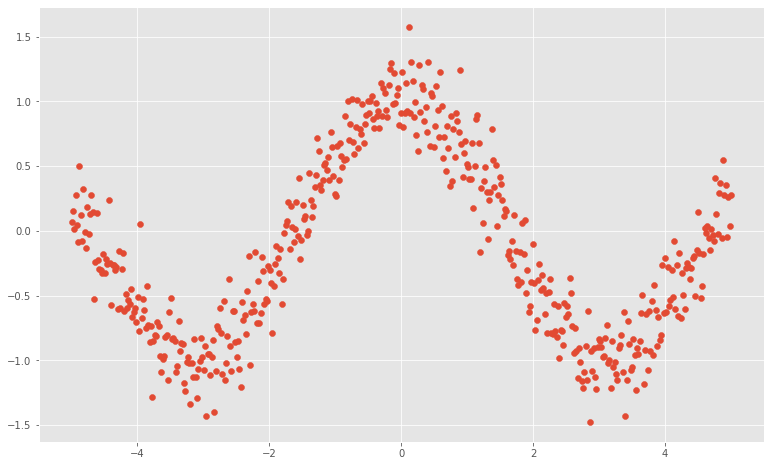

In [54]:
# data
n_points = 500

x = np.linspace(start=-5, stop=5, num=n_points)
y = np.cos(x) + np.random.normal(loc=0.0, scale=0.2, size=n_points)

plt.scatter(x, y);

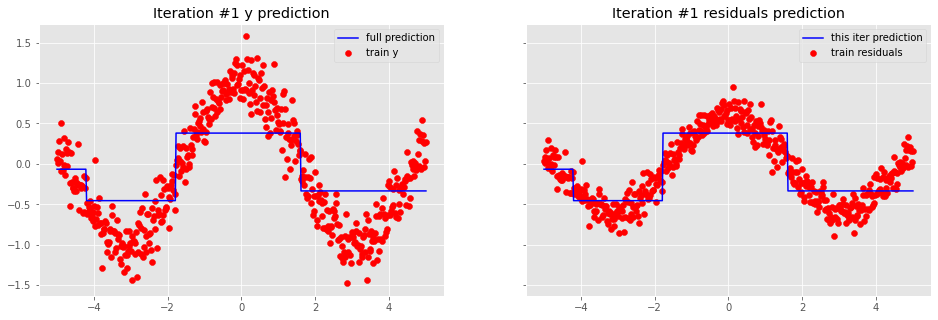

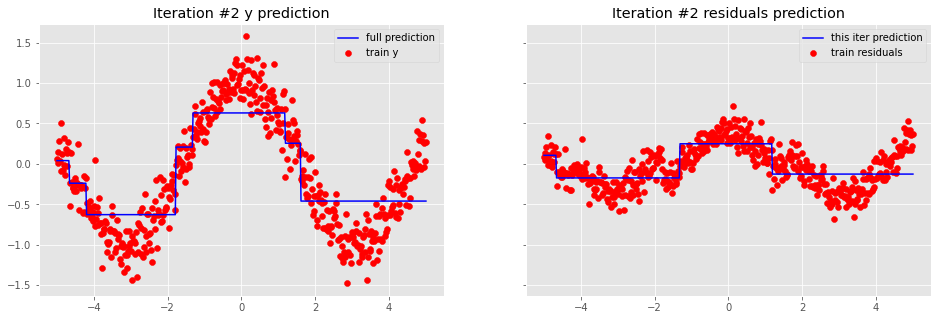

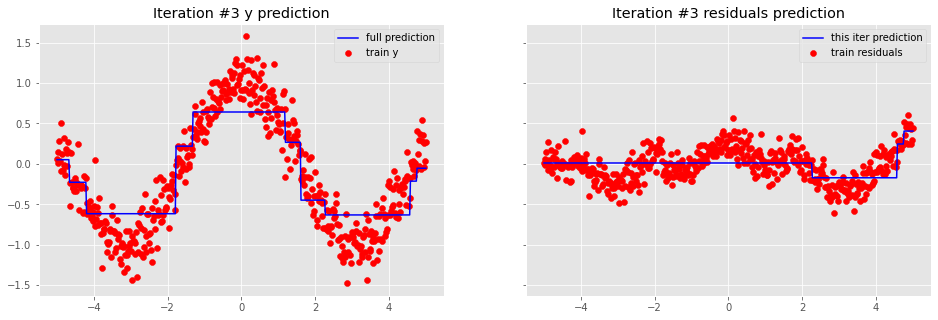

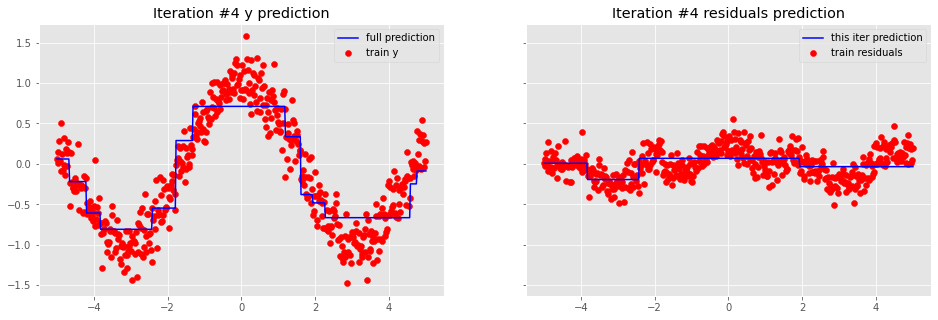

In [67]:
n_estimators = 4 # кол-во деревьев в бустинге
max_depth = 2 # максимальная глубина дерева
learning_rate = 0.3 # скорость обучения

trees_list = []

prediction = np.zeros_like(y) # initial prediction, 0's
for i in range(n_estimators):
    # residuals: -learning_rate * gradient
    residuals = (-1 * learning_rate) * (2 * (prediction - y))
    
    # new tree
    tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    tree = tree.fit(x.reshape(len(x), 1), residuals)
    
    prediction = prediction + tree.predict(x.reshape(len(x), 1))
    
    trees_list.append(tree)
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 5))
    
    ax1.scatter(x, y, color='red', label='train y')
    ax1.plot(x, prediction, color='blue', label='full prediction')
    ax1.set_title(f'Iteration #{i+1} y prediction')
    ax1.legend()
    
    ax2.scatter(x, residuals, color='red', label='train residuals')
    ax2.plot(x, tree.predict(x.reshape(len(x), 1)), color='blue', label='this iter prediction')
    ax2.set_title(f'Iteration #{i+1} residuals prediction')
    ax2.legend()
    
    plt.show();

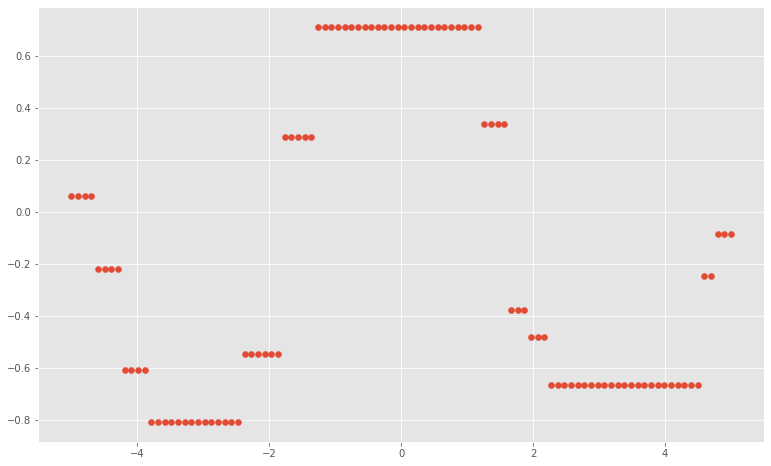

In [68]:
# предсказание на неизвестных данных
n_points = 100

new_x = np.linspace(start=-5, stop=5, num=n_points)
y_pred = np.zeros_like(new_x) # init by 0

for tree in trees_list:
    y_pred = y_pred + tree.predict(new_x.reshape(len(new_x), 1))

plt.scatter(new_x, y_pred);

Главная хитрость - в градиенте. Типа `y - prediction` - это как раз градиент. Чтобы это понять, нам надо продифференцировать функцию потерь $L(y, f)$ по $f$, нашим функциям от предикторов:  
$$ L(y, f) = \frac{1}{2}\sum\limits_{i=1}^m (f(x_{i}) - y_{i})^2 $$  

> здесь мы берем $ \frac{1}{2} $ вместо $ \frac{1}{m} $ (что дало бы нам именно **среднюю** квадратичную ошибку) для более удобного дифференцирования (чтоб двоечки сократились). Какой бы множитель мы не добавили, минимум от этого не сместится, так что принципиальной разницы нет.  

Это $L_2$, MSE, среднеквадратичная ошибка, классика для регрессии. Решаем относительно $f$, получаем:  
$$ (\frac{1}{2}\sum\limits_{i=1}^m (f(x_{i}) - y_{i})^2)' = \frac{1}{2}(\sum\limits_{i=1}^m (f(x_{i}) - y_{i})^2)' = \frac{1}{2}\sum\limits_{i=1}^m((f(x_{i}) - y_{i})^2)' = \frac{1}{2}\sum\limits_{i=1}^m(2(f(x_{i}) - y_{i})(f(x_{i}) - y_{i})') = \frac{1}{2}*2*\sum\limits_{i=1}^m(-1(f(x_{i}) - y_{i}) = \sum\limits_{i=1}^m(y_{i} - f(x_{i}))$$  

Вот поэтому мы и говорим, что остатки, $(y_{i} - f(x_{i})$ - это градиент. Ну то есть тут должна быть какая-то правильная аргументация относительно того, что мы используем не число, а вектор (не сумму, а вектор предсказаний); и про то, что это дифференцирование в пространстве функций. В общем, см. подробнее [тут](https://habr.com/ru/company/ods/blog/327250/). Тут криво, но вроде ясно.  

Вот да, наверное так: градиент по вектору предсказаний. Типа как их изменить, чтобы лосс стал меньше. Это зависит от функции, которая предсказания нам генерит. Что-то такое. 

## class

И вот чтоб теперь перейти к классификации - нужно выбрать лосс и взять его градиент по вектору предсказаний. Ну конечно же мы возьмем наш любимый логлосс, он же бинарная кросс-энтропия (BCE).  

Там есть разные записи (в зависимости от того, какие у нас метки классов: {-1,1} или {0,1}), у них, соответственно, разные дифференциалы. Взял отсюда: https://habr.com/ru/company/ods/blog/327250/ (но ваще надо бы с этим поупражняться)  

Для размышлений:  
* про логрег: https://habr.com/ru/company/ods/blog/323890/. Стоит обратить внимание на раздув про логарифм шансов и вероятность (вероятность - это сигмоида от логарифма шансов, по формулкам). А еще про отступ (margin) классификации
* про линейные модели: https://habr.com/ru/company/ods/blog/322076/  

Запишу здесь еще формулу LogLoss для лэйблов {-1, 1} из статьи про логрег:  
$$\log(1+\exp^{-y\hat{y}})$$  

, где $\hat{y}$ - это сырое предсказание, логит, логарифм шансов, который сигмоидой переводится в вероятность. А $y\hat{y}$ тогда - отступ (margin) классификации  


Вот у Дьяконова всё по полочкам: [Логистическая функция ошибки](https://dyakonov.org/2018/03/12/%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F-%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8/)

In [70]:
def sigmoid(array):
    return 1 / (1 + np.exp(-1 * array)) # = np.exp(array) / (1 + np.exp(array))

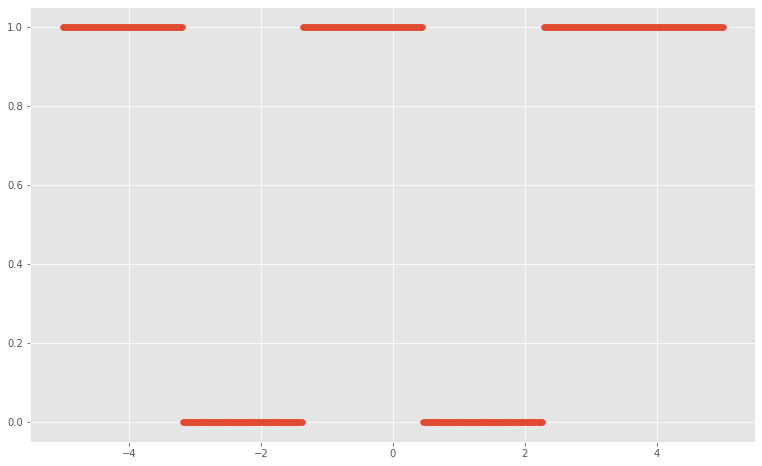

In [71]:
# data
n_points = 550
class_len = 100

x = np.linspace(start=-5, stop=5, num=n_points)
y = np.array([])

# {0, 1}
for i in range(n_points // class_len):
    y = np.concatenate([y, np.ones(class_len) - (i % 2)])
    
# # {-1, 1}
# for i in range(n_points // class_len):
#     y = np.concatenate([y, np.ones(class_len) - 2*(i % 2)])
    
y = np.concatenate([y, np.ones(n_points % class_len)])

plt.scatter(x, y);

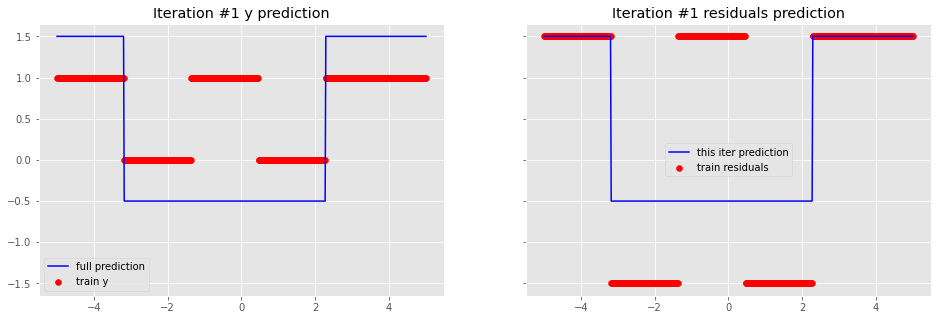

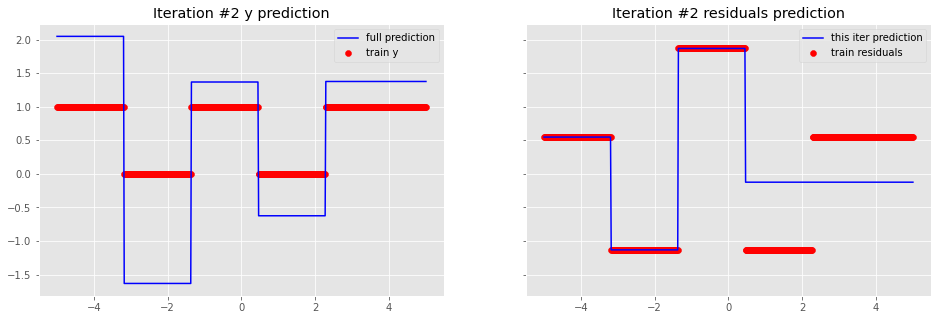

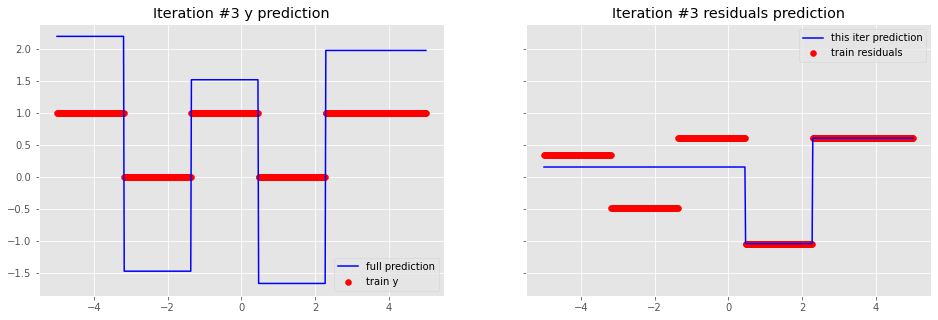

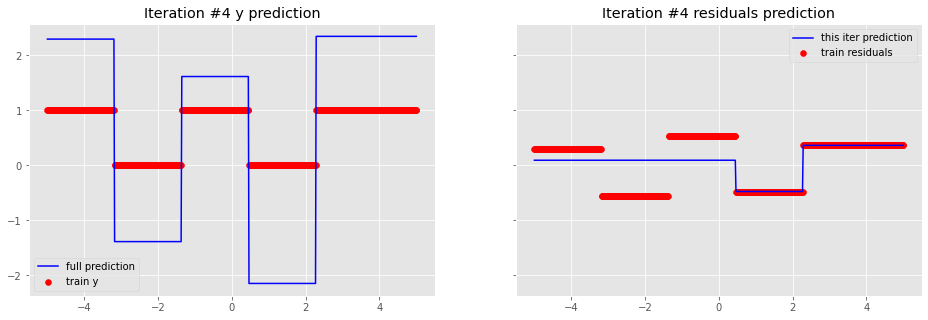

In [73]:
n_estimators = 4 # кол-во деревьев в бустинге
max_depth = 2 # максимальная глубина дерева
learning_rate = 3. # скорость обучения

trees_list = []

prediction = np.zeros_like(y) # init by 0. Sigmoid(0) = 0.5
for i in range(n_estimators):
    # residuals: -learning_rate * gradient
    # residuals = (2 * y) / (1 + np.exp(2*y*prediction)) # {-1, 1}
    residuals = (-1*learning_rate) * (-1*y + sigmoid(prediction)) # {0, 1}
    
    # new tree
    tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    tree = tree.fit(x.reshape(len(x), 1), residuals)
    
    prediction = prediction + tree.predict(x.reshape(len(x), 1))
    
    trees_list.append(tree)
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 5))
    
    ax1.scatter(x, y, color='red', label='train y')
    ax1.plot(x, prediction, color='blue', label='full prediction')
    ax1.set_title(f'Iteration #{i+1} y prediction')
    ax1.legend()
    
    ax2.scatter(x, residuals, color='red', label='train residuals')
    ax2.plot(x, tree.predict(x.reshape(len(x), 1)), color='blue', label='this iter prediction')
    ax2.set_title(f'Iteration #{i+1} residuals prediction')
    ax2.legend()
    
    plt.show();

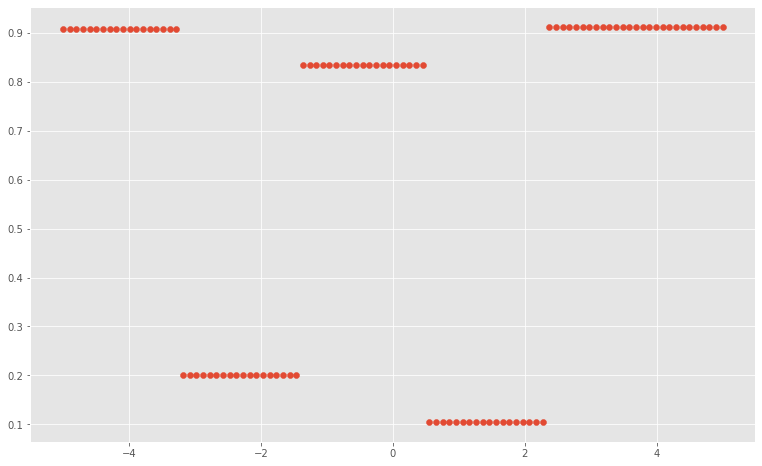

In [74]:
# предсказание на неизвестных данных
n_points = 100

new_x = np.linspace(start=-5, stop=5, num=n_points)
logits = np.zeros_like(new_x) # init by 0. Sigmoid(0) = 0.5

for tree in trees_list:
    logits = logits + tree.predict(new_x.reshape(len(new_x), 1))

plt.scatter(new_x, sigmoid(logits));

Ну, конечно по классификации остались вопросики:  
* как считать при {0,1} (или всегда переводят в {0,1}?); 
* расчет градиента (логлосса) по шагам пройти;  
* логиты, логарифм шанса и т.п. - надо понять, где там что, что как интерпретировать, какие области определения у чего и т.п. И типа что работает только в логреге, а что - везде (в том числе в бустинге).  

Но общий алгоритм вроде понятен.

**UPD:**
Я тут еще повтыкал в математику, и всё понял насчет {0,1} и его градиента. Смотрим:  
$$Logloss/CrossEntropy(y, p) = -y * \log(p) -(1-y)*\log(1-p)$$  
Тут $p$ - это вероятностное предсказание, от 0 до 1. А $y$ - истинный лэйбл, 0 или 1.  
$p$ мы получаем сигмоидой от логита. Т.е.:  
$$p = \sigma(logit) = \frac{e^{logit}}{1+e^{logit}} $$
Тогда мы можем записать нашу функцию потерь так:  
$$Logloss/CrossEntropy(y, logit) = -y * \log\left(\frac{e^{logit}}{1+e^{logit}}\right) -(1-y)*\log\left(1-\frac{e^{logit}}{1+e^{logit}}\right)$$  
Немного упростим (главный прикол - в свойствах логарифма):  
$$-y * \log\left(\frac{e^{logit}}{1+e^{logit}}\right) -(1-y)*\log\left(1-\frac{e^{logit}}{1+e^{logit}}\right) = -y * \log\left(\frac{e^{logit}}{1+e^{logit}}\right) -(1-y)*\log\left(\frac{1}{1+e^{logit}}\right) = $$  
$$= -y * \biggl(\log(e^{logit})-\log(1+e^{logit})\biggr) - (1-y)*\biggl(\log(1)-\log(1+e^{logit})\biggr) = -y*\log(e^{logit}) +y*\log(1+e^{logit}) - (1-y)*(-\log(1+e^{logit})) = $$  
$$= -y*logit +y*\log(1+e^{logit})) + \log(1+e^{logit}) -y*\log(1+e^{logit}) = -y*logit + \log(1+e^{logit})$$ 
****
**Итого:**  
$$Logloss/CrossEntropy(y, logit) = -y*logit + \log(1+e^{logit})$$  

И вот если от этого дела посчитать градиент по _logit_, получаем такое:

$$ \frac{\partial \left(-y*logit + \log(1+e^{logit})\right)}{\partial logit} = \frac{\partial \left(-y*logit\right)}{\partial logit} + \frac{\partial \left(\log(1+e^{logit})\right)}{\partial logit} = -y + \frac{1}{1+e^{logit}} * \frac{\partial (1+e^{logit})}{\partial logit} = -y + \frac{1}{1+e^{logit}} * e^{logit} = -y + \frac{e^{logit}}{1+e^{logit}} = -y + \sigma(logit)$$

**Итого:**  
$$ \nabla_{logit} Logloss/CrossEntropy(y, logit) = \frac{\partial Logloss/CrossEntropy(y, logit)}{\partial logit} = -y+p = -y + \sigma(logit) = -y + \frac{e^{logit}}{1+e^{logit}} $$

### Отдельно для краткости:  
$ y \in \{0, 1\}; logit \in (-\inf, \inf) $  
$ p = \sigma(logit) = \frac{e^{logit}}{1+e^{logit}} $  
$ Logloss/CrossEntropy(y, p) = -y * \log(p) -(1-y)*\log(1-p) $  
$ Logloss/CrossEntropy(y, logit) = -y*logit + \log(1+e^{logit}) $  
$ \nabla_{logit} Logloss/CrossEntropy(y, logit) = \frac{\partial Logloss/CrossEntropy(y, logit)}{\partial logit} = -y+p = -y + \sigma(logit) = -y + \frac{e^{logit}}{1+e^{logit}} $

Кстати, из $ p = \sigma(logit) $ следует такое:  
* $ \lim_{logit\to-\infty}p = 0 $
* $ \lim_{logit\to+\infty}p = 1 $
* $ logit = 0 \to p=0.5 $

## Алгоритм GBM на деревьях:  

0. делаем какое-то первичное предсказание (вектор), обычно константа;
1. считаем градиент функции потерь на предсказании относительно этого самого предсказании (тоже вектор);  
2. обучаем простенькое дерево решений (регрессионное), используя в качестве таргета рассчитанный шагом ранее градиент со знаком минус (т.е. антиградиент);
3. дерево сохраняем в свой списочек, и апдэйтим предсказание: новое предсказание = старое предсказание + предсказание последнего обученного дерева;  
4. если не выполнено условие ранней остановки (кол-во итераций, лосс и т.п.) - идём на п.1.  

Предсказание на новых данных - делаем то же первичное предсказание, и потом бежим по всем деревьям, добавляя их предсказание. PROFIT!  

## UPD

Формула ансамбля:  
$$a_N(X) = a_{N-1}(X) + \gamma_N b_N(X)$$  

Здесь $X$ - входная матрица, $b_i(X)$ - предсказание $i$-того базового алгоритма, $\gamma_i$ - вес для $i$-того базового алгоритма, $a_i(X)$ - предсказание ансамбля на $i$-том шаге.  

Т.е. к нашей схеме добавляется $\gamma_i$, вес. Именно коэффициент при базовой модели помогает настроить ансамбль так, чтобы получить наиболее точное предсказание. Откуда его берем? Получаем из задачи минимизации, перебирая разные числа.  

Тогда алгоритм получается таким:

In [3]:
def find_coef(y_true, y_pred, old_prediction, loss_func, 
              min_candidate=0.1, max_candidate=10, n_candidates=1000):
    candidates = np.linspace(min_candidate, max_candidate, n_candidates)
    
    best_loss = loss_func(y_true, old_prediction + y_pred)
    best_coef = 1
    
    for coef in candidates:
        new_pred = old_prediction + coef * y_pred
        new_loss = loss_func(y_true, new_pred)
        
        if new_loss < best_loss:
            best_coef = coef
            best_loss = new_loss
            
    return best_coef

### regr

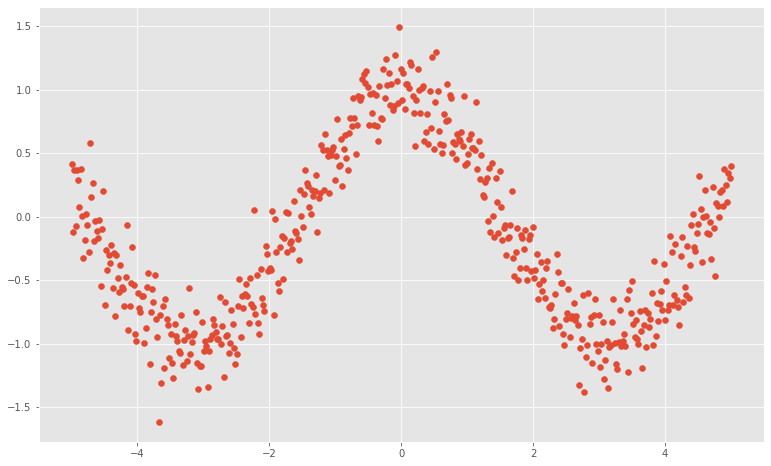

In [4]:
# data
n_points = 500

x = np.linspace(start=-5, stop=5, num=n_points)
y = np.cos(x) + np.random.normal(loc=0.0, scale=0.2, size=n_points)

plt.scatter(x, y);

In [5]:
def loss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

def loss_gradient(y_true, y_pred):
    return y_pred - y_true

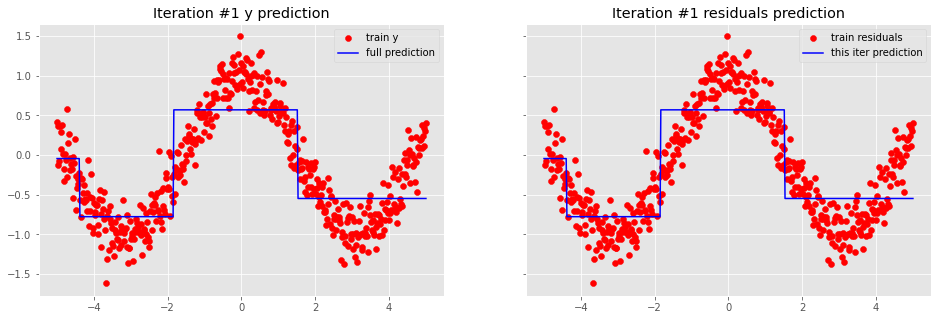

coef=1


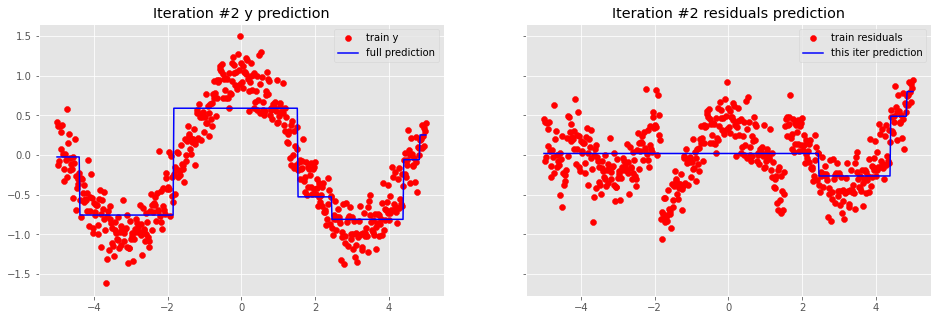

coef=1


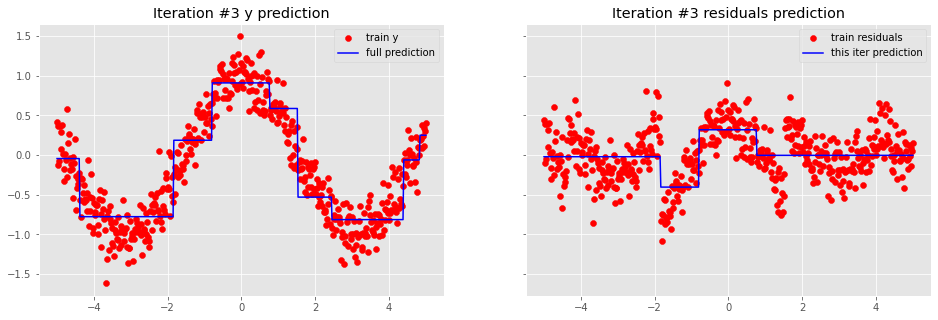

coef=1


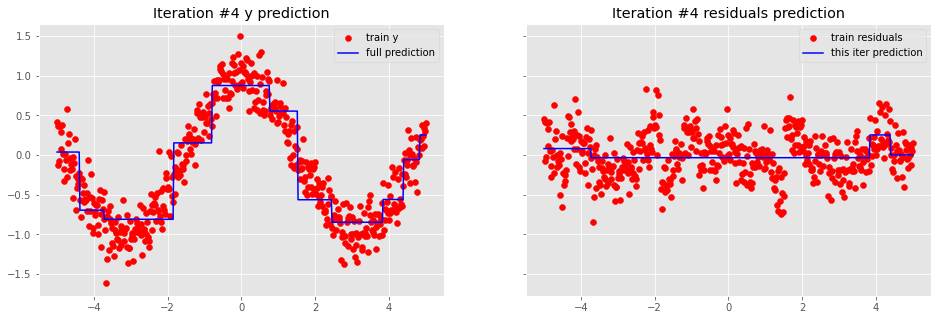

coef=1


In [6]:
n_estimators = 4 # кол-во деревьев в бустинге
max_depth = 2 # максимальная глубина дерева
learning_rate = 1 # скорость обучения

trees_list = []
coefs = []

prediction = np.zeros_like(y) # initial prediction, 0's
for i in range(n_estimators):
    # residuals: -learning_rate * gradient
    residuals = (-1 * learning_rate) * loss_gradient(y_true=y, y_pred=prediction)
    
    # new tree
    tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    tree = tree.fit(x.reshape(len(x), 1), residuals)
    
    tree_pred = tree.predict(x.reshape(len(x), 1))
    trees_list.append(tree)
    
    # search coef
    coef = find_coef(
        y_true=y, 
        y_pred=tree_pred, 
        old_prediction=prediction,
        loss_func=loss, 
        min_candidate=0.1, 
        max_candidate=10, 
        n_candidates=1000
    )
    coefs.append(coef)
    
    # new prediction
    prediction = prediction + coef * tree_pred
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 5))
    
    ax1.scatter(x, y, color='red', label='train y')
    ax1.plot(x, prediction, color='blue', label='full prediction')
    ax1.set_title(f'Iteration #{i+1} y prediction')
    ax1.legend()
    
    ax2.scatter(x, residuals, color='red', label='train residuals')
    ax2.plot(x, tree.predict(x.reshape(len(x), 1)), color='blue', label='this iter prediction')
    ax2.set_title(f'Iteration #{i+1} residuals prediction')
    ax2.legend()
    
    plt.show();
    print(f'coef={coef}')

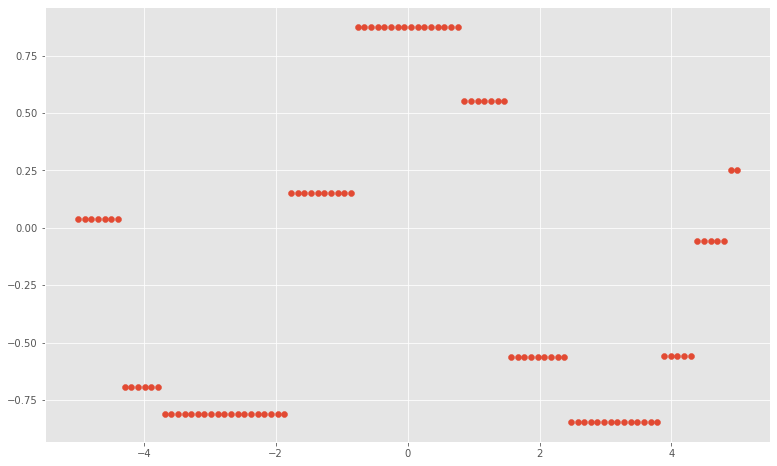

In [7]:
# предсказание на неизвестных данных
n_points = 100

new_x = np.linspace(start=-5, stop=5, num=n_points)
y_pred = np.zeros_like(new_x) # init by 0

for coef, tree in zip(coefs, trees_list):
    y_pred = y_pred + coef * tree.predict(new_x.reshape(len(new_x), 1))

plt.scatter(new_x, y_pred);

### class

In [8]:
def sigmoid(array):
    return 1 / (1 + np.exp(-1 * array)) # = np.exp(array) / (1 + np.exp(array))

In [9]:
def loss(y_true, y_pred):
    pred_proba = sigmoid(y_pred)
    return np.sum(-1 * (y_true*np.log(pred_proba) + (1 - y_true)*np.log(1 - pred_proba)))

def loss_gradient(y_true, y_pred):
    pred_proba = sigmoid(y_pred)
    return pred_proba - y_true

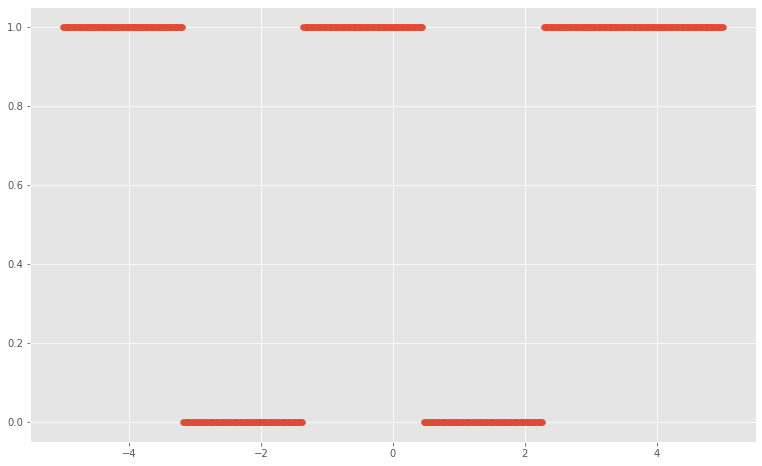

In [10]:
# data
n_points = 550
class_len = 100

x = np.linspace(start=-5, stop=5, num=n_points)
y = np.array([])

# {0, 1}
for i in range(n_points // class_len):
    y = np.concatenate([y, np.ones(class_len) - (i % 2)])
    
y = np.concatenate([y, np.ones(n_points % class_len)])

plt.scatter(x, y);

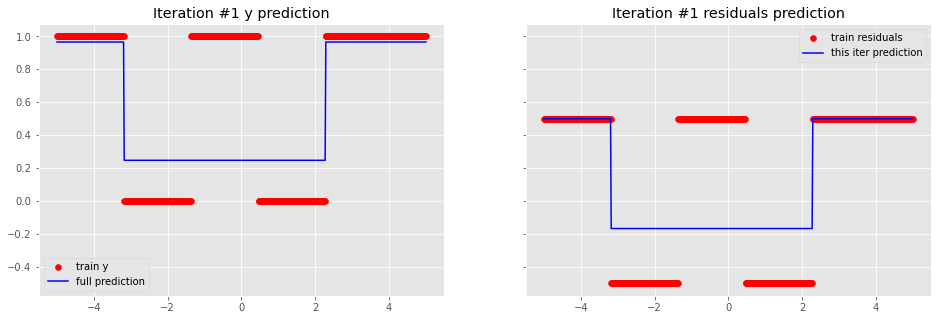

coef=6.6702702702702705


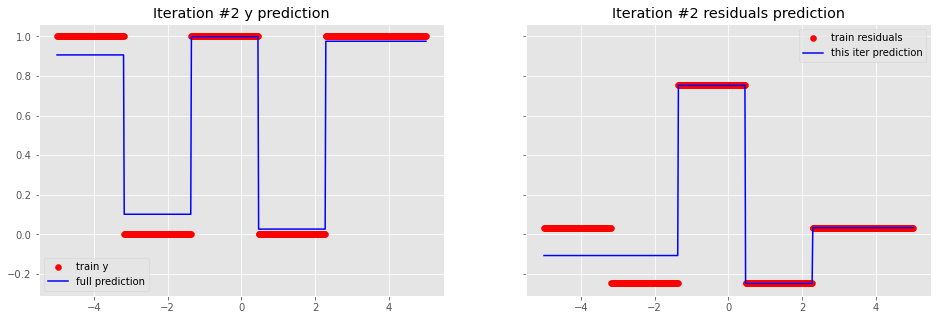

coef=10.0


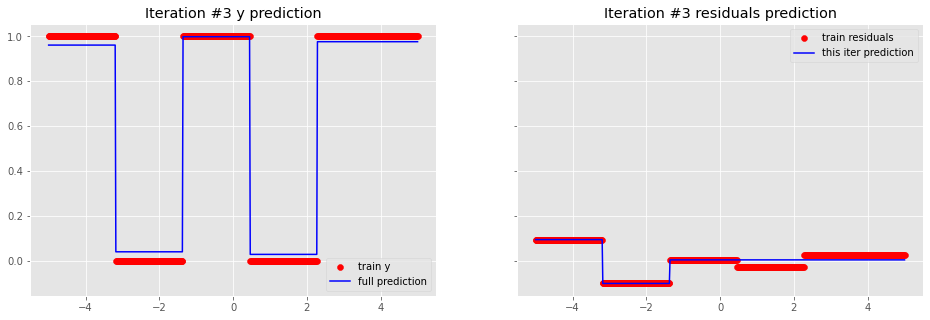

coef=10.0


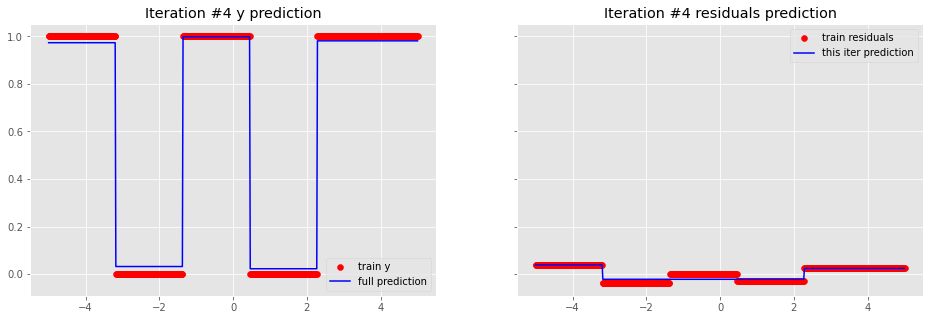

coef=10.0


In [11]:
n_estimators = 4 # кол-во деревьев в бустинге
max_depth = 2 # максимальная глубина дерева
learning_rate = 1 # скорость обучения

trees_list = []
# sigmoid(prediction)
prediction = np.zeros_like(y) # init by 0. Sigmoid(0) = 0.5

for i in range(n_estimators):
    # residuals: -learning_rate * gradient
    residuals = (-1 * learning_rate) * loss_gradient(y_true=y, y_pred=prediction)
    
    # new tree
    tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    tree = tree.fit(x.reshape(len(x), 1), residuals)
    
    tree_pred = tree.predict(x.reshape(len(x), 1))
    trees_list.append(tree)
    
    # search coef
    coef = find_coef(
        y_true=y, 
        y_pred=tree_pred, 
        old_prediction=prediction,
        loss_func=loss, 
        min_candidate=0.1, 
        max_candidate=10, 
        n_candidates=1000
    )
    coefs.append(coef)
    
    # new prediction
    prediction = prediction + coef * tree_pred
    
    # plot
    prediction_proba = sigmoid(prediction)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 5))
    
    ax1.scatter(x, y, color='red', label='train y')
    ax1.plot(x, prediction_proba, color='blue', label='full prediction')
    ax1.set_title(f'Iteration #{i+1} y prediction')
    ax1.legend()
    
    ax2.scatter(x, residuals, color='red', label='train residuals')
    ax2.plot(x, tree.predict(x.reshape(len(x), 1)), color='blue', label='this iter prediction')
    ax2.set_title(f'Iteration #{i+1} residuals prediction')
    ax2.legend()
    
    plt.show();
    print(f'coef={coef}')

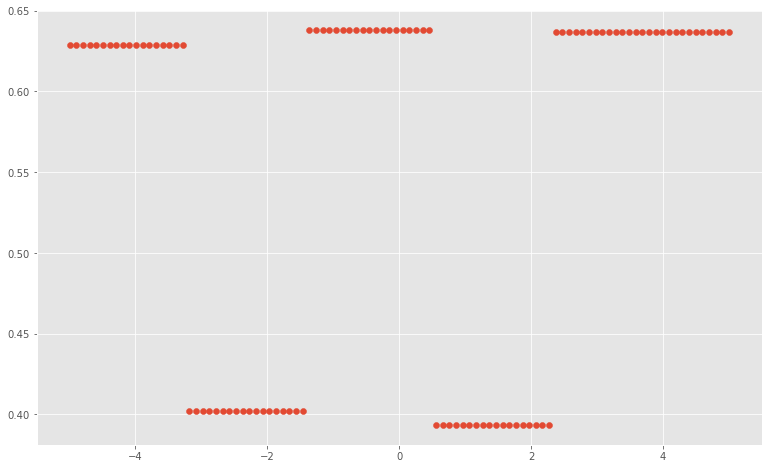

In [12]:
# предсказание на неизвестных данных
n_points = 100

new_x = np.linspace(start=-5, stop=5, num=n_points)
logits = np.zeros_like(new_x) # init by 0. Sigmoid(0) = 0.5

for tree in trees_list:
    logits = logits + tree.predict(new_x.reshape(len(new_x), 1))

plt.scatter(new_x, sigmoid(logits));